In [ ]:
library(tidyverse)
library(lubridate)
library(tseries)
library(forecast)
library(xts)
library(PerformanceAnalytics)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is suppos

Warning message in adf.test(price_ts):
“p-value greater than printed p-value”



	Augmented Dickey-Fuller Test

data:  price_ts
Dickey-Fuller = -0.28358, Lag order = 12, p-value = 0.99
alternative hypothesis: stationary



Warning message in adf.test(price_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  price_ts
Dickey-Fuller = -14.84, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary



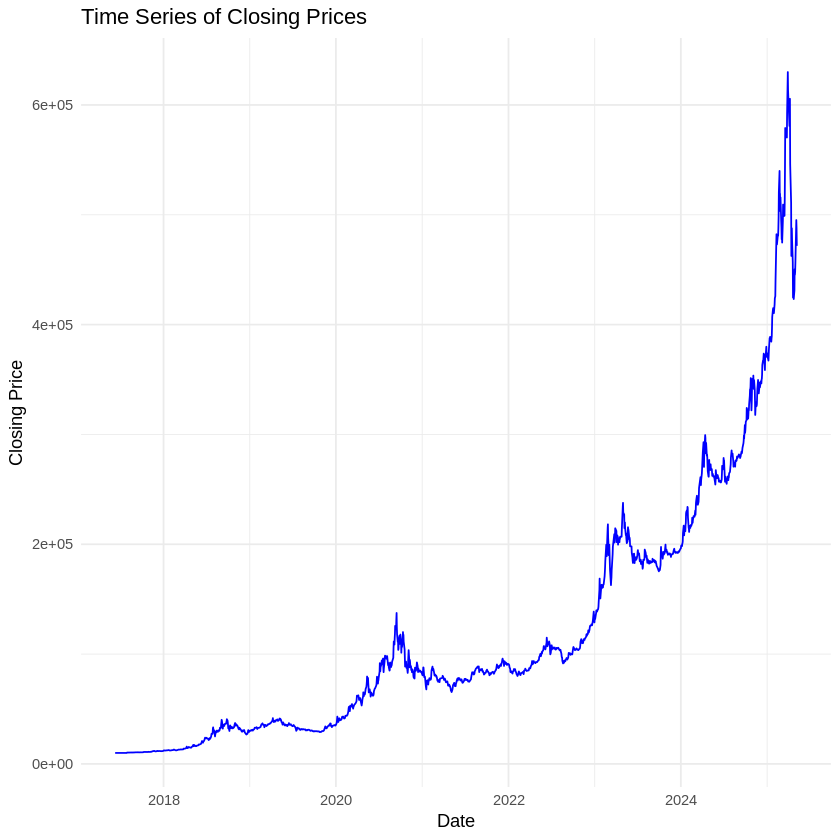

Series: price_ts 
ARIMA(3,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ar3     ma1     ma2      mean
      -0.2430  -0.8449  0.1518  0.3952  0.8263  240.8991
s.e.   0.0481   0.0466  0.0263  0.0429  0.0635  115.8272

sigma^2 = 19435500:  log likelihood = -18646.41
AIC=37306.83   AICc=37306.89   BIC=37345.68

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.6895854 4401.608 2127.201 NaN  Inf 0.6909385 0.0001611722

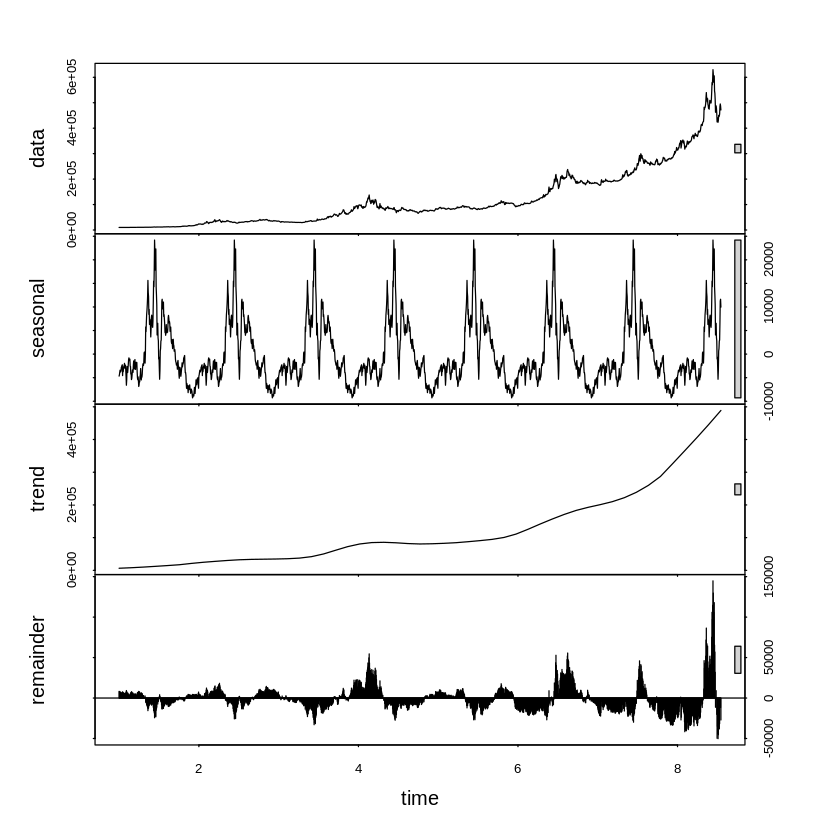


	Shapiro-Wilk normality test

data:  sample(df$Return, min(5000, nrow(df)))
W = 0.93946, p-value < 2.2e-16

[1] "Annualized Sharpe Ratio: 1.389"
Standard deviation of daily returns: 0.02463 


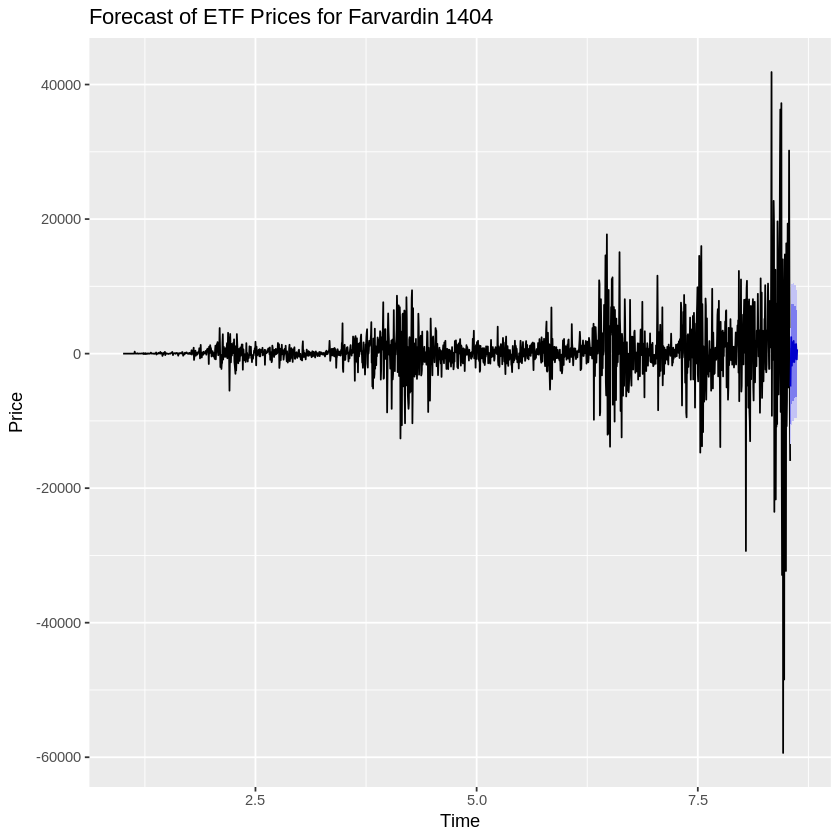

In [ ]:
options(xts.warn_dplyr_breaks_lag = FALSE)

# Read and preprocess data
df <- read.csv("Lotus Gold Com.ETF.csv", stringsAsFactors = FALSE) %>%
  setNames(c("Ticker", "Date", "First", "High", "Low", "Close",
             "Value", "Vol", "OpenInt", "Per", "Open", "Last")) %>%
  mutate(Date = ymd(Date)) %>%
  arrange(Date)

# Plot closing prices
ggplot(df, aes(x = Date, y = Close)) +
  geom_line(color = "blue") +
  labs(title = "Time Series of Closing Prices", x = "Date", y = "Closing Price") +
  theme_minimal()

# Time-series analysis
price_ts <- ts(df$Close, frequency = 252)  # Assuming 252 trading days/year

# ADF test for stationarity
adf_result <- adf.test(price_ts)
print(adf_result)

if (adf_result$p.value > 0.05) {
  price_ts <- diff(price_ts)  # Difference if non-stationary
  print(adf.test(price_ts))   # Re-test after differencing
}

# Decomposition
decomp <- stl(ts(df$Close, frequency = 252), s.window = "periodic")
plot(decomp)

# ARIMA modeling
fit <- auto.arima(price_ts)
summary(fit)

# Forecast
forecast_result <- forecast(fit, h = 20)
autoplot(forecast_result) +
  labs(title = "Forecast of ETF Prices for Farvardin 1404", y = "Price")

# Returns analysis
df <- df %>%
  mutate(Return = c(NA, diff(log(Close)))) %>%
  na.omit()

# Shapiro-Wilk test (on a sample if returns are large)
shapiro_test <- shapiro.test(sample(df$Return, min(5000, nrow(df))))
print(shapiro_test)

# Sharpe ratio (using xts)
returns_xts <- xts(df$Return, order.by = df$Date)
sharpe <- SharpeRatio.annualized(returns_xts, Rf = 0)
print(paste("Annualized Sharpe Ratio:", round(sharpe, 4)))

# Volatility
cat("Standard deviation of daily returns:", round(sd(df$Return), 5), "\n")

In [ ]:
risk_metrics <- function(returns, Rf = 0) {
  sd_return <- sd(returns) * 100

  sharpe_ratio <- SharpeRatio.annualized(returns, Rf = Rf, scale = 252)

  cat("### Investment Risk Metrics ###\n")
  cat("1. Daily Return Standard Deviation (Risk):", round(sd_return, 2), "%\n")
  cat("2. Annualized Sharpe Ratio (Risk-Free Rate = 0%):", round(sharpe_ratio, 2), "\n")

  cat("\n### Interpretation ###\n")
  if (sd_return < 2) {
    cat("- Low Standard Deviation (<2%): Low volatility fund, suitable for conservative investors.\n")
  } else if (sd_return < 5) {
    cat("- Medium Standard Deviation (2%-5%): Fund with balanced risk.\n")
  } else {
    cat("- High Standard Deviation (>5%): High volatility fund, suitable for risk-tolerant investors.\n")
  }

  if (sharpe_ratio > 1) {
    cat("- High Sharpe Ratio (>1): Excellent return relative to risk.\n")
  } else if (sharpe_ratio > 0) {
    cat("- Positive Sharpe Ratio (>0): Acceptable return relative to risk.\n")
  } else {
    cat("- Negative Sharpe Ratio: Poor return relative to risk.\n")
  }
}

risk_metrics(returns_xts)

### معیارهای ریسک سرمایه‌گذاری ###
1. انحراف معیار روزانه بازدهی (ریسک): 2.46 %
2. شاخص شارپ سالانه (بازه بدون ریسک = 0%): 1.39 

### تفسیر ###
- انحراف معیار متوسط (2%-5%): صندوق با ریسک متعادل.
- شاخص شارپ بالا (>1): بازدهی عالی نسبت به ریسک.


**Part 2**


Data Structure:
Rows: 27
Columns: 6
$ name <chr> "Tehran (Mehrabad Airport)", "Tehran (Mehrabad Airport)", "Tehran…
$ lat  <dbl> 35.6931, 35.6931, 35.6931, 35.6931, 35.6931, 35.6931, 35.6931, 35…
$ tmax <dbl> 17.6, 17.6, 15.4, 12.4, 11.2, 11.6, 9.0, 7.6, 8.0, 6.0, 3.6, 5.2,…
$ tmin <dbl> 6.6, 7.8, 7.2, 6.0, 7.4, 6.8, 0.0, 1.2, -1.2, -1.2, -1.2, 0.0, -0…
$ tm   <dbl> 11.2, 11.7, 10.7, 9.5, 9.7, 8.3, 4.2, 3.4, 3.1, 2.0, 0.9, 2.2, 2.…
$ rain <dbl> 0.00, 0.00, 0.00, 0.00, 1.30, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,…

Missing Values Summary:
name  lat tmax tmin   tm rain 
   0    0    0    0    0    0 

Correlation Analysis Results:

	Pearson's product-moment correlation

data:  temp and rain
t = -1.1336, df = 25, p-value = 0.2677
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5545312  0.1734786
sample estimates:
      cor 
-0.221112 


Pearson Correlation Coefficient: -0.221 


`geom_smooth()` using formula = 'y ~ x'



Regression Analysis Results:

Call:
lm(formula = rain ~ tm, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0256 -0.8839 -0.5503  0.0175  8.0538 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   1.1276     0.6100   1.849   0.0764 .
tm           -0.1134     0.1000  -1.134   0.2677  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.856 on 25 degrees of freedom
Multiple R-squared:  0.04889,	Adjusted R-squared:  0.01085 
F-statistic: 1.285 on 1 and 25 DF,  p-value: 0.2677


Regression Equation:
Rainfall = 1.128 + -0.113 × Temperature
R-squared: 0.049 
Adjusted R-squared: 0.011 


`geom_smooth()` using formula = 'y ~ x'


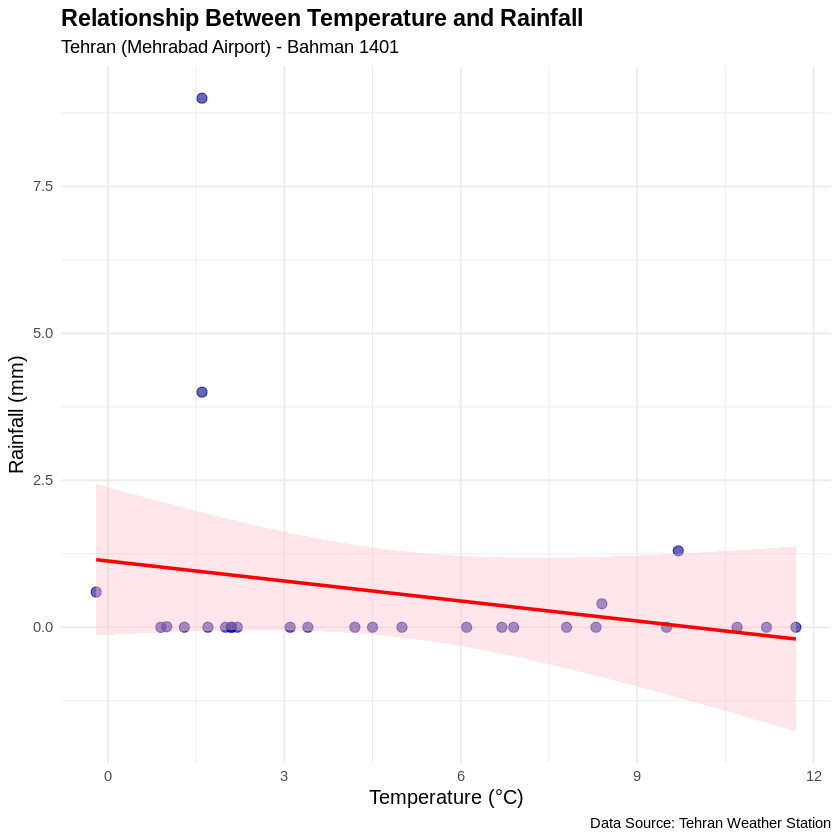

In [ ]:
weather <- read_csv("Tehran (Mehrabad Airport).csv",
                   col_types = cols(),
                   na = c("", "NA", "NaN")) %>%
  drop_na()

cat("\nData Structure:\n")
glimpse(weather)

cat("\nMissing Values Summary:\n")
print(colSums(is.na(weather)))

correlation_analysis <- function(temp, rain) {
  tryCatch({
    cor_val <- cor(temp, rain, use = "complete.obs")
    cor_test <- cor.test(temp, rain)

    cat("\nCorrelation Analysis Results:\n")
    print(cor_test)
    cat("\nPearson Correlation Coefficient:", round(cor_val, 3), "\n")

    return(list(correlation = cor_val, test = cor_test))
  }, error = function(e) {
    message("Correlation analysis failed: ", e$message)
    return(NULL)
  })
}

cor_results <- correlation_analysis(weather$tm, weather$rain)

weather_plot <- ggplot(weather, aes(x = tm, y = rain)) +
  geom_point(color = "darkblue", alpha = 0.6, size = 2.5) +
  geom_smooth(method = "lm", color = "red", se = TRUE, fill = "pink") +
  labs(title = "Relationship Between Temperature and Rainfall",
       subtitle = "Tehran (Mehrabad Airport) - Bahman 1401",
       x = "Temperature (°C)",
       y = "Rainfall (mm)",
       caption = "Data Source: Tehran Weather Station") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14),
        axis.title = element_text(size = 12))

print(weather_plot)

lm_analysis <- function(data) {
  model <- lm(rain ~ tm, data = data)
  smry <- summary(model)

  cat("\nRegression Analysis Results:\n")
  print(smry)

  coeffs <- coef(model)
  cat("\nRegression Equation:\n")
  cat(sprintf("Rainfall = %.3f + %.3f × Temperature\n",
              coeffs[1], coeffs[2]))
  cat("R-squared:", round(smry$r.squared, 3), "\n")
  cat("Adjusted R-squared:", round(smry$adj.r.squared, 3), "\n")

  return(model)
}

weather_model <- lm_analysis(weather)

ggsave("temperature_rainfall_relationship.png",
       plot = weather_plot,
       width = 8, height = 6, dpi = 300)